# Определение возраста покупателей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Описание данных

Данные взяты с сайта `ChaLearn Looking at People`. Они находятся в папке `/datasets/faces/`. В нашем распоряжении одна папка со всеми изображениями (`/final_files`) и CSV-файл `labels.csv` с двумя колонками: `file_name` и `real_age`. 

## Исследовательский анализ данных

In [1]:
# Подключение библиотек

import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Настройки
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
# Константы

SEED = 12345 # значение для параметра seed

In [3]:
# Функция для построения графиков

def draw_graph(data, feature, bins=100, category=False):
    
    plt.figure(figsize=(15, 15))
    plt.subplot(2, 1, 1)
    
    if category == False:        
        sns.histplot(data=data[feature], kde=True, bins=bins, color='cadetblue')
        plt.grid(linewidth = 0.5, linestyle = '--')
        plt.title('Feature "{}" distribution'.format(feature), 
                  fontdict={'fontsize': 14, 'fontfamily': 'cursive'})
        plt.ylabel('count / density')
    else:
        sns.countplot(data=data, x=feature, palette='rainbow')
        plt.grid(linewidth = 0.5, linestyle = '--')
        plt.title('Feature "{}" distribution'.format(feature), 
                  fontdict={'fontsize': 14, 'fontfamily': 'cursive'})
    
    plt.subplot(2, 1, 2)
    sns.boxplot(data=data, x=feature, color='#FFDAB9')
    plt.grid(linewidth = 0.5, linestyle = '--')
    plt.title('Boxplot for feature "{}"'.format(feature), 
              fontdict={'fontsize': 14, 'fontfamily': 'cursive'})
    
    plt.show()

In [4]:
# Загрузка данных

labels = pd.read_csv('/datasets/faces/labels.csv')

train_datagen = ImageDataGenerator(rescale=1./255)

train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=SEED)

Found 7591 validated image filenames.


In [5]:
# Размер датасета

print(f'Количество строк датафрейма: {labels.shape[0]}')
print(f'Количество столбцов датафрейма: {labels.shape[1]}')

Количество строк датафрейма: 7591
Количество столбцов датафрейма: 2


In [6]:
# Просмотр основной информации

labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [7]:
# Просмотр данных

labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [8]:
# Распаковка данных

features, target = next(train_gen_flow)

In [9]:
# Размер выборки

features.shape

(32, 224, 224, 3)

findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.


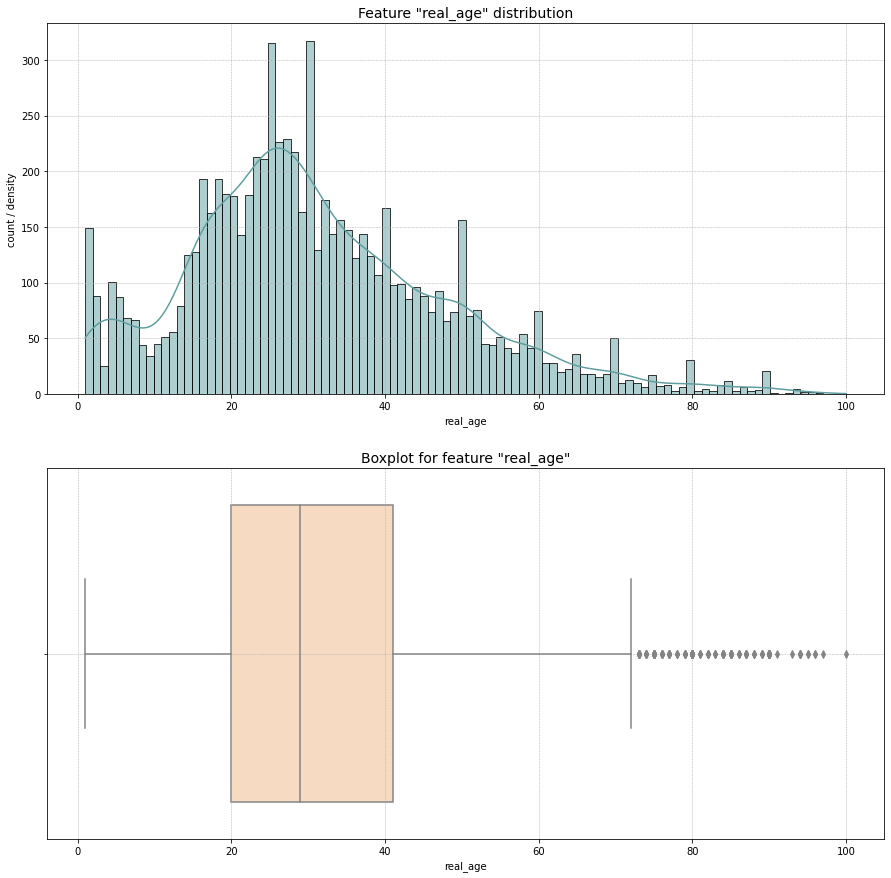

In [10]:
# Строим график распределения возраста для данной выборки

draw_graph(labels, 'real_age')

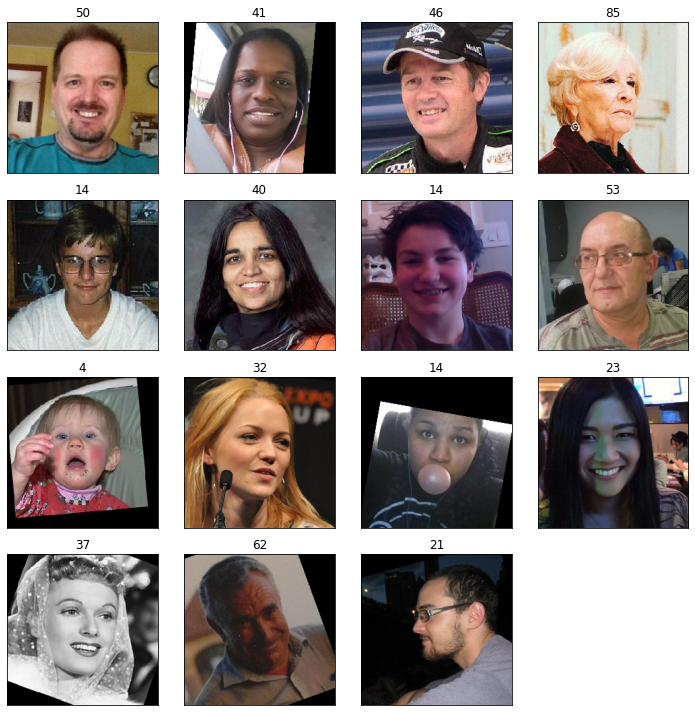

In [18]:
# Печать нескольких фотографий из датасета

fig = plt.figure(figsize=(10, 10))

for i in range(15):
    fig.add_subplot(4, 4, i + 1)
    plt.imshow(features[i])
    plt.title(target[i])
    plt.tick_params(left= False, 
                    bottom= False, 
                    labelleft=False, 
                    labelbottom=False)

    # для компактности удаляем оси и прижимаем изображения друг к другу
plt.xticks([])
plt.yticks([])
plt.tight_layout()

#### Вывод:
Количество строк и столбцов таблицы: 7591 и 2, соответственно. Предварительно можно считать, что этих данных достаточно для исследования. Пропущенных значений нет. Данные представляют собой изображения, размер которых выбран равным 224 на 224. 

Исходя из графика распределения возраста: чаще всего в выборке встречаются люди в возрасте от 20 до 40 лет. Медианное значение на отметке чуть менее 30 лет.

Исходя из напечатанных на экране фото: присутствуют чёрно-белые фотографии, не на всех фото видно лицо полностью. Данные моменты могут неоднозначно сказаться на определении возраста обучаемой моделью. Все изображения отцентрированы по горизонтали и вертикали.

## Обучение модели

Перенесём сюда код обучения модели и её результат вывода на экран.

(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50 

import numpy as np
import pandas as pd

def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(validation_split=0.25, horizontal_flip=True, rescale=1./255)
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path+'/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=123)

    return train_datagen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path+'/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=123)

    return test_datagen_flow

def create_model(input_shape):
    backbone = ResNet50(input_shape=(224, 224, 3), weights='imagenet', include_top=False)
    optimizer = Adam(lr=0.0001)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error',
                  metrics=['mae'])

    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=5,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

```

```
Train for 178 steps, validate for 60 steps
Epoch 1/5
178/178 - 48s - loss: 231.8583 - mae: 10.8973 - val_loss: 809.7251 - val_mae: 23.3727
Epoch 2/5
178/178 - 40s - loss: 71.1930 - mae: 6.3715 - val_loss: 651.2076 - val_mae: 20.3267
Epoch 3/5
178/178 - 39s - loss: 46.3944 - mae: 5.1905 - val_loss: 328.3667 - val_mae: 13.5618
Epoch 4/5
178/178 - 39s - loss: 34.2900 - mae: 4.4413 - val_loss: 220.7596 - val_mae: 11.2116
Epoch 5/5
178/178 - 39s - loss: 26.5013 - mae: 3.9269 - val_loss: 92.6077 - val_mae: 7.1357
60/60 - 10s - loss: 92.6077 - mae: 7.1357
Test MAE: 7.1357

```

## Анализ обученной модели

Выбрана модель RESNET50, которая также обучена на более чем 1 миллионе изображений из базы данных ImageNet. ResNet50 может классифицировать до 1000 объектов. Принимает на вход цветные изображения размером 224×224 пикселей. Данная сеть была разработана с целью избавиться от затухающих и взрывных градиентов.

При обучении использованы следующие параметры и улучшения: `Sequential` из Keras - линейный набор слоев нейронной сети, слой `ResNet50`, слой `GlobalAveragePooling2D` - глобальной средней подвыборки, слой `Dense` - полносвязный слой с активацией нейронов `ReLU`, оптимизатор `Adam`.

Удалось получить значение метрики `MAE` на уровне `3.9269` на обучающей выборке и `7.1357` на тестовой выборке. Стоит учесть, что подобная ошибка (минимум в 7 лет) возможно, в каких-то моментах, способна оказать негативное влияние на бизнес заказчика.